In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import pprint
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import json
import models
from execution import *

In [2]:
model_str = 'gpt3_1T'
model = models.models[model_str]
# set model hyperparams
l = model['l']
e = model['e']
f = 4 * e
model['f'] = f
h = model['h']
depth = model['depth']
print('model is {}'.format(model))

# set data hyperparms
if model_str == 'gpt3_1T':
    total_tokens = 1 * 10**12
else:
    total_tokens = 300 * 10**9
num_samples = total_tokens / l
if model_str == 'vit_era5':
    num_ep = 80
    num_samples = 350000 * num_ep
print('training on {} samples'.format(num_samples))
global_batch_size = 4096

model is {'l': 2048, 'e': 25600, 'h': 160, 'depth': 128, 'f': 102400}
training on 488281250.0 samples


In [3]:
systems = ['A100-NVL4', 'A100-NVL8', 'A100-NVL64', 'H200-NV4', 'H200-NVL8', 'H200-NVL64', 'B200-NVL4', 'B200-NVL8', 'B200-NVL64']
config_names = ['A100', 'A100', 'A100', 'H200', 'H200', 'H200', 'B200', 'B200', 'B200']
nvlink_sizes = [4, 8, 64, 4, 8, 64, 4, 8, 64]

A100-NVL4 4
at 4096 gpus, time = 89.02320513097393
base performance taken at A100-NVL4,256
A100-NVL8 8
at 4096 gpus, time = 80.82279669900198
A100-NVL64 64
at 4096 gpus, time = 79.38781712356963
H200-NV4 4
at 4096 gpus, time = 28.648304085409574
H200-NVL8 8
at 4096 gpus, time = 27.766867415695806
H200-NVL64 64
at 4096 gpus, time = 26.88360151326084
B200-NVL4 4
at 4096 gpus, time = 11.856923716023074
B200-NVL8 8
at 4096 gpus, time = 11.78907788581214
B200-NVL64 64
at 4096 gpus, time = 11.217082651087386


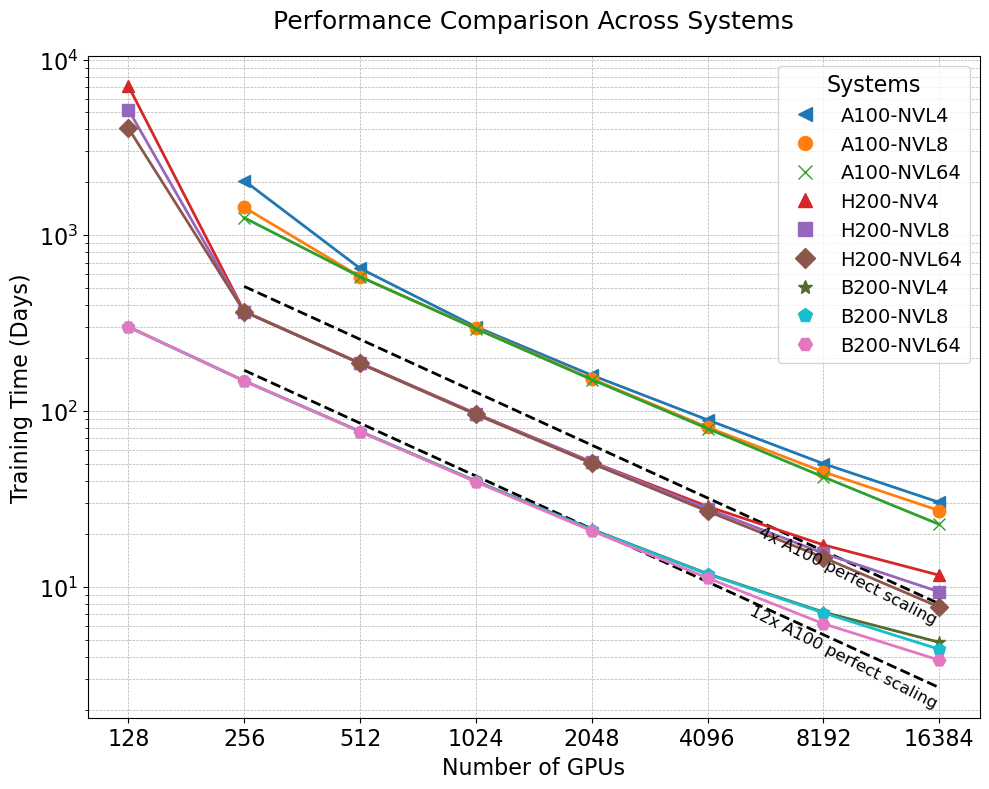

In [4]:
#### TRAINING TIME vs #GPUS ######
styles = ['<', 'o', 'x', '^', 's', 'D', '*', 'p', 'H', 'v', 'P']
st_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#556b2f', '#17becf', '#e377c2', '#7f7f7f', '#bcbd22']

# Create figure and axis
fig, axs = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
axs.tick_params(axis='both', which='major', labelsize=16)
axs.tick_params(axis='both', which='minor', labelsize=16)

# Initialize legend handles
sys_str_handles = []
gpu_count_to_read = 4096

for st, sys_str in enumerate(systems):
    x = np.load('outputs/exec_2d_{}_{}.npy'.format(model_str, sys_str), allow_pickle=True)
    nvc = 0
    for nvs, t_max, t_min, n_gpus, configs in x:
        print(sys_str, nvs)
        if len(t_max) == 0:
            continue
        time = [(num_samples / tm) / (3600 * 24) for tm in t_max]
        
        pidx = list(n_gpus).index(gpu_count_to_read)
        print("at {} gpus, time = {}".format(n_gpus[pidx], time[pidx]))
        line, = axs.plot(n_gpus, time, label=f'nv = {nvs}', marker=styles[st], markersize=9, color=st_colors[st], linewidth=2)
        
        if sys_str == 'A100-NVL4':
            print('base performance taken at {},{}'.format(sys_str, n_gpus[0]))
            x_start = n_gpus[0]
            x_end = n_gpus[-1]
            fac = x_end / x_start
            y_start = time[0]/4
            y_end = time[0]/(4 * fac)
            # perfect scaling at 4X
            axs.plot([x_start, x_end], [y_start, y_end], linestyle='--', linewidth=2, color='k')
            axs.annotate('4x A100 perfect scaling', xy=(x_end, y_end), xytext=(0, 58),
                         textcoords="offset points", fontsize=12, verticalalignment='top', horizontalalignment='right', rotation=-27)
            
            y_start = time[0]/12
            y_end = time[0]/(12 * fac)
            # perfect scaling at 4X
            axs.plot([x_start, x_end], [y_start, y_end], linestyle='--', linewidth=2, color='k')
            axs.annotate('12x A100 perfect scaling', xy=(x_end, y_end), xytext=(0, 61),
                         textcoords="offset points", fontsize=12, verticalalignment='top', horizontalalignment='right', rotation=-27)

        # axs.fill_between(n_gpus, t_max, t_min, color=st_colors[st], alpha=0.2)
        axs.set_yscale('log', base=10)
        axs.set_xscale('log', base=2)
        axs.set_xticks(n_gpus)
        axs.set_xticklabels(n_gpus)
        axs.set_xlabel('Number of GPUs', fontsize=16)
        axs.set_ylabel('Training Time (Days)', fontsize=16)
        # axs.set_yticks(10. ** np.arange(1, 3))
        # axs.set_ylim([5,5000])
        nvc += 1
    sys_str_handles.append(Line2D([0], [0], marker=styles[st], color=st_colors[st], label=sys_str, linestyle='None', markersize=10))

# Add legends
# nv_legend = axs.legend(handles=nv_handles, title="NVLink Size", fontsize=14, loc='upper left', title_fontsize=16)
# perfect_scaling_handle = Line2D([0], [0], linestyle='--', color='k', linewidth=2, label='Perfect scaling')
sys_str_legend = axs.legend(handles=sys_str_handles, title="Systems", fontsize=14, loc='upper right', title_fontsize=16)
# axs.add_artist(nv_legend)

# Additional aesthetics
axs.grid(True, which='both', linestyle='--', linewidth=0.5)
axs.set_title('Performance Comparison Across Systems', fontsize=18, pad=20)

fig.tight_layout()
plt.savefig('outputs/exec_2d_{}.png'.format(model_str), dpi=400)

A100-NVL4 4
base performance taken at A100-NVL4,256
A100-NVL8 8
A100-NVL64 64
H200-NV4 4
H200-NVL8 8
H200-NVL64 64
B200-NVL4 4
B200-NVL8 8
B200-NVL64 64


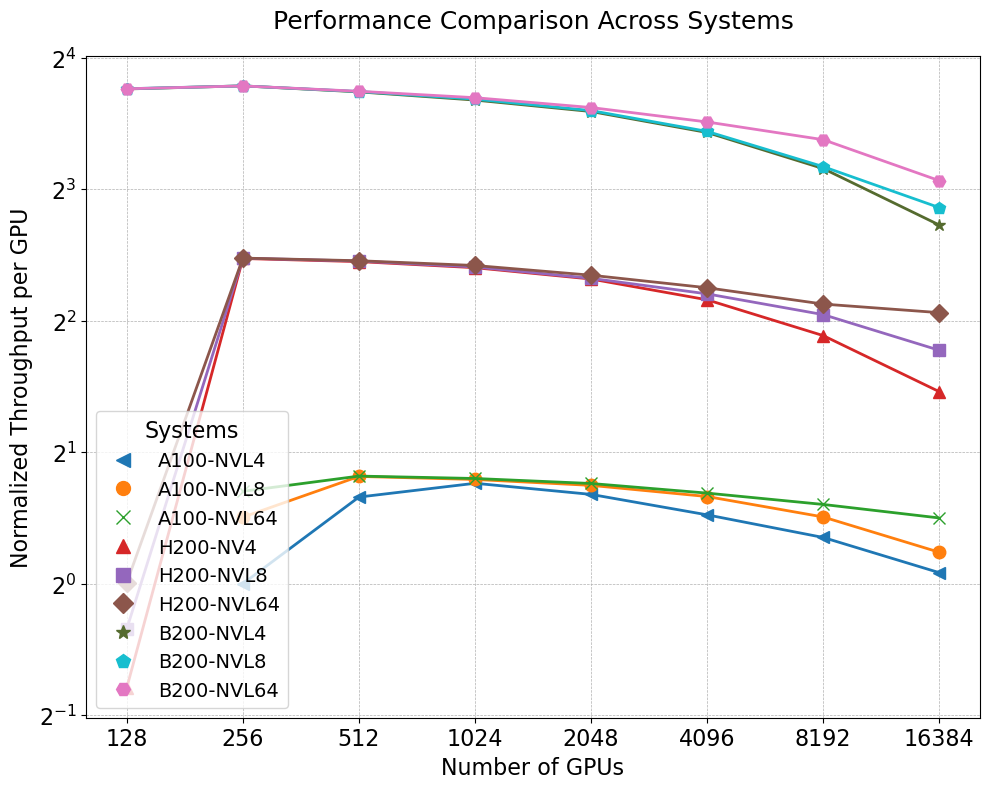

In [5]:
### PERFORMANCE PER GPU vs #GPUS ####
styles = ['<', 'o', 'x', '^', 's', 'D', '*', 'p', 'H', 'v', 'P']
st_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#556b2f', '#17becf', '#e377c2', '#7f7f7f', '#bcbd22']

# Create figure and axis
fig, axs = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
axs.tick_params(axis='both', which='major', labelsize=16)
axs.tick_params(axis='both', which='minor', labelsize=16)

# Initialize legend handles
sys_str_handles = []

gpu_count_to_read = 2048

for st, sys_str in enumerate(systems):
    x = np.load('outputs/exec_2d_{}_{}.npy'.format(model_str, sys_str), allow_pickle=True)
    nvc = 0
    for nvs, t_max, t_min, n_gpus, configs in x:
        print(sys_str, nvs)
        if len(t_max) == 0:
            continue
        # time = [(num_samples / tm) / (3600 * 24) for tm in t_max]
        if sys_str == 'A100-NVL4':
            print('base performance taken at {},{}'.format(sys_str, n_gpus[0]))
            perf_base = (t_max[0] / n_gpus[0])
            # perf_base = 1 / ((num_samples / t_max[0]) / (3600 * 24)) / n_gpus[0]
        perf = [(tm / ng) / perf_base for tm, ng in zip(t_max, n_gpus)]
        # perf = [((1 / ((num_samples / tm) / (3600 * 24))) / ng) / perf_base for tm, ng in zip(t_max, n_gpus)]
        # pidx = list(n_gpus).index(gpu_count_to_read)
        # print("at {} gpus, perf = {}".format(n_gpus[pidx], perf[pidx]))
        line, = axs.plot(n_gpus, perf, label=f'nv = {nvs}', marker=styles[st], markersize=9, color=st_colors[st], linewidth=2)
        axs.set_yscale('log', base=2)
        axs.set_xscale('log', base=2)
        axs.set_xticks(n_gpus)
        axs.set_xticklabels(n_gpus)
        axs.set_xlabel('Number of GPUs', fontsize=16)
        axs.set_ylabel('Normalized Throughput per GPU', fontsize=16)
        # axs.set_yticks(10. ** np.arange(1, 3))
        # axs.set_ylim([5,5000])
        nvc += 1
    sys_str_handles.append(Line2D([0], [0], marker=styles[st], color=st_colors[st], label=sys_str, linestyle='None', markersize=10))

# Add legends
sys_str_legend = axs.legend(handles=sys_str_handles, title="Systems", fontsize=14, loc='lower left', title_fontsize=16)
# axs.add_artist(nv_legend)

# Additional aesthetics
axs.grid(True, which='both', linestyle='--', linewidth=0.5)
axs.set_title('Performance Comparison Across Systems', fontsize=18, pad=20)

fig.tight_layout()
plt.savefig('outputs/exec_perf_2d_{}.png'.format(model_str), dpi=400)

[4 2 2 4 4 4 4 8]
[1 1 1 1 1 1 1 1]
[ 32 128 128 128 128 128 128 128]
[ 1  1  2  2  4  8 16 16]
[4096 4096 2048 2048 1024  512  256  256]
[186.80850022 184.86943744 157.34375117  78.67187558  71.79045402
  68.34974323  66.62938784  33.31469392]


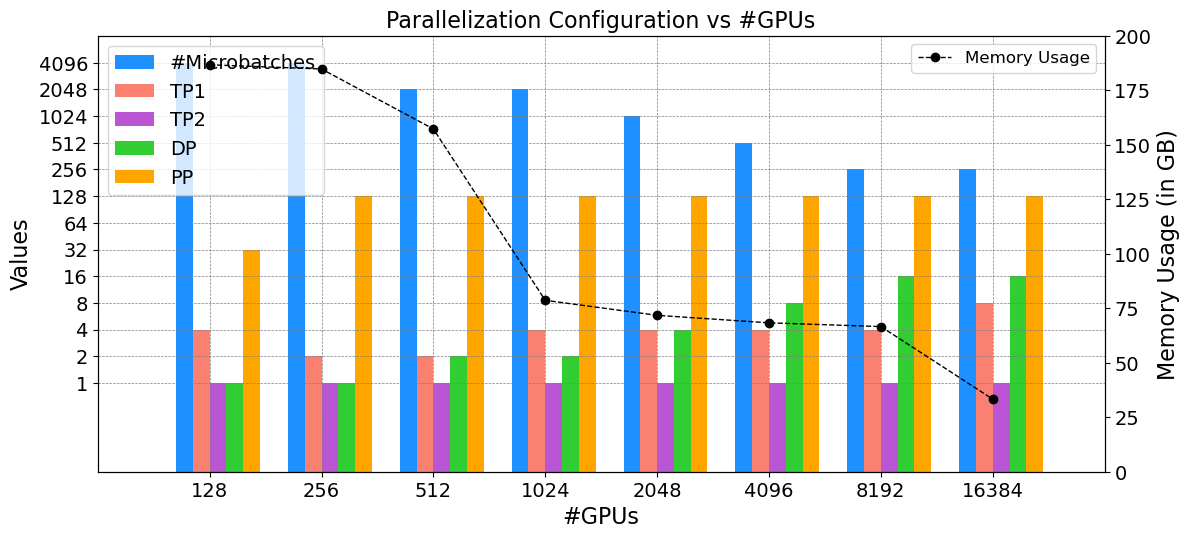

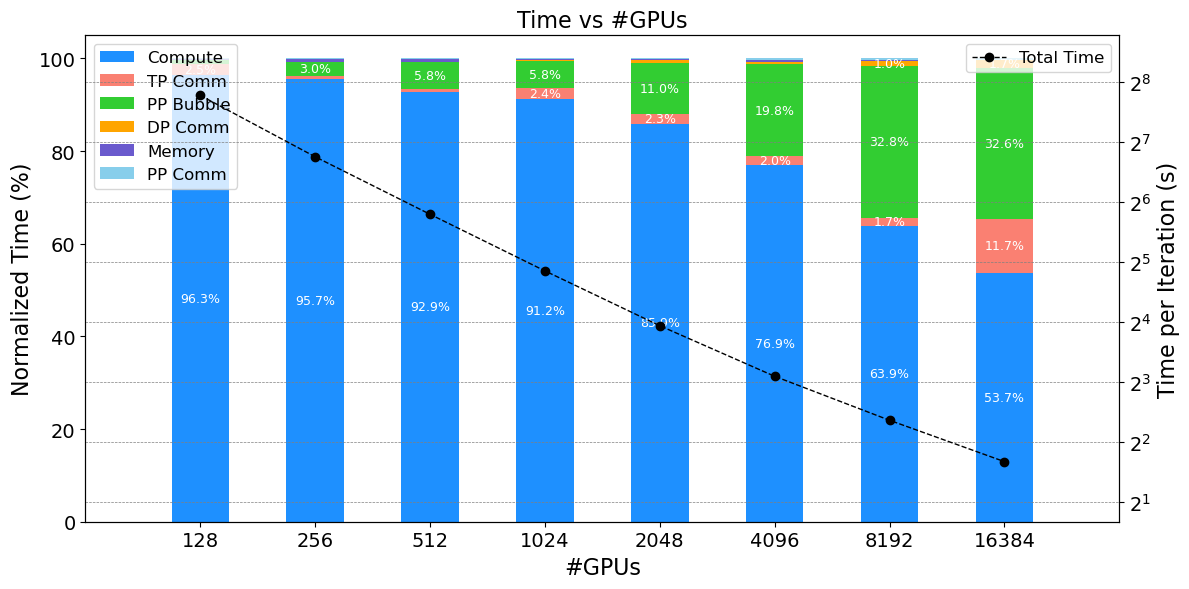

<Figure size 640x480 with 0 Axes>

In [6]:
### BEST CONFIG AND TIME PARTITION vs #GPUS ####
import matplotlib.pyplot as plt
import numpy as np

sys_str = 'B200-NVL8'
x = np.load('outputs/exec_2d_{}_{}.npy'.format(model_str, sys_str), allow_pickle=True)
for nvs, t_max, t_min, n_gpus, configs in x:
    break
        
n_values = n_gpus
m_values =  np.array([(global_batch_size/c[0][2]['dp'])/c[0][2]['mbs'] for c in configs]).astype(int)
tp1_values = np.array([c[0][2]['tp1'] for c in configs])
tp2_values = np.array([c[0][2]['tp2'] for c in configs])
pp_values = np.array([c[0][2]['pp'] for c in configs])
dp_values = np.array([c[0][2]['dp'] for c in configs])
mem_values = np.array([c[0][3]['mem'] for c in configs])

print(tp1_values)
print(tp2_values)
print(pp_values)
print(dp_values)
print(m_values)
print(mem_values)

time_part1 = np.array([c[0][3]['t_comp'] for c in configs])
time_part2 = np.array([c[0][3]['t_comm'] for c in configs])
time_part3 = np.array([c[0][3]['t_bubble'] for c in configs])
time_part4 = np.array([c[0][3]['t_dp_comm'] for c in configs])
time_part5 = np.array([c[0][3]['t_mem_exposed'] for c in configs])
time_part6 = np.array([c[0][3]['t_pp_comm'] for c in configs])
time_total = time_part1 + time_part2 + time_part3 + time_part4 + time_part5 + time_part6

# Create the plot
plt.figure(figsize=(12, 10))

# First plot: m, tp, dp, pp as a function of n
plt.subplot(2, 1, 1)
bar_width = 0.2
log_n_values = np.log2(n_values)

bar_width = 0.15  # Width of the bars

# Plotting the bars
plt.bar(log_n_values - 1.5 * bar_width, m_values, bar_width, label='#Microbatches', color='dodgerblue')
plt.bar(log_n_values - 0.5 * bar_width, tp1_values, bar_width, label='TP1', color='salmon')
plt.bar(log_n_values + 0.5 * bar_width, tp2_values, bar_width, label='TP2', color='mediumorchid')  # Added next to TP
plt.bar(log_n_values + 1.5 * bar_width, dp_values, bar_width, label='DP', color='limegreen')
plt.bar(log_n_values + 2.5 * bar_width, pp_values, bar_width, label='PP', color='orange')


# plt.bar(log_n_values - 1.5 * bar_width, m_values, bar_width, label='#Microbatches', color='dodgerblue')
# plt.bar(log_n_values - 0.5 * bar_width, tp_values, bar_width, label='TP', color='salmon')
# plt.bar(log_n_values + 0.5 * bar_width, dp_values, bar_width, label='DP', color='limegreen')
# plt.bar(log_n_values + 1.5 * bar_width, pp_values, bar_width, label='PP', color='orange')

plt.xlabel('#GPUs', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.title('Parallelization Configuration vs #GPUs', fontsize=16)
plt.xticks(log_n_values, n_values, fontsize=14)
plt.yscale('log', base=2)
top = max(max(m_values), max(tp1_values), max(dp_values), max(pp_values), max(tp2_values))
top2 = int(np.ceil(np.log2(top)))+1
plt.ylim([0.1, top * 2])
plt.yticks([2**i for i in range(0, top2)], [2**i for i in range(0, top2)], fontsize=14)
plt.xlim([np.log2(n_values[0]) - 1, np.log2(n_values[-1]) + 1])
plt.legend(fontsize=14, loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()

# Add mem_values as a twin axis on the right
ax3 = plt.gca().twinx()
ax3.plot(log_n_values, mem_values, color='black', linewidth=1, linestyle='--', marker='o', label='Memory Usage')
ax3.set_ylabel('Memory Usage (in GB)', fontsize=16, color='black')
ax3.tick_params(axis='y', labelcolor='black', labelsize=14)
ax3.set_ylim(0, 200)

# Add legend for the line plot
lines, labels = ax3.get_legend_handles_labels()
plt.legend(lines, labels, fontsize=12, loc='upper right')

plt.tight_layout()

# Second plot: Time vs n as a stacked bar plot with percentages and total time line
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.5

# Normalize the time parts
time_parts = np.array([time_part1, time_part2, time_part3, time_part4, time_part5, time_part6])
time_parts_normalized = time_parts / time_total[:, np.newaxis].T * 100

# Create the stacked bar plot
colors = ['dodgerblue', 'salmon', 'limegreen', 'orange', 'slateblue', 'skyblue']
labels = ['Compute', 'TP Comm', 'PP Bubble', 'DP Comm', 'Memory', 'PP Comm']
bottom = np.zeros(len(n_values))

for i, (height, color, label) in enumerate(zip(time_parts_normalized, colors, labels)):
    p = ax1.bar(log_n_values, height, bottom=bottom, label=label, color=color, width=bar_width)
    bottom += height

    # Add percentage text
    for j, h in enumerate(height):
        if h > 1:  # Only show percentage if it's greater than 1%
            ax1.text(log_n_values[j], bottom[j] - h/2, f'{h:.1f}%', ha='center', va='center', color='white', fontsize=9)

ax1.set_xlabel('#GPUs', fontsize=16)
ax1.set_ylabel('Normalized Time (%)', fontsize=16)
ax1.set_title('Time vs #GPUs', fontsize=16)
ax1.set_xticks(log_n_values)
ax1.set_xticklabels(n_values, fontsize=14)
ax1.set_xlim([np.log2(n_values[0]) - 1, np.log2(n_values[-1]) + 1])
ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(axis='y', labelsize=14)

# Adjust y-axis to make smaller bars more visible
ax1.set_ylim(0, 105)  # Set to slightly over 100% to give some headroom

# Add the total time line plot on the right y-axis
ax2 = ax1.twinx()
ax2.plot(log_n_values, time_total, color='black', linewidth=1, linestyle='--', marker='o', label='Total Time')
ax2.set_ylabel('Time per Iteration (s)', fontsize=16, color='black')
ax2.tick_params(axis='y', labelcolor='black', labelsize=14)
ax2.set_yscale('log', base=2)

# Set y-axis limits for total time
ax2.set_ylim(min(time_total) / 2, max(time_total) * 2)

# Add legend for the line plot
lines, labels = ax2.get_legend_handles_labels()
ax1.legend(fontsize=12, loc='upper left')
ax2.legend(lines, labels, fontsize=12, loc='upper right')

plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()
plt.savefig('outputs/parconfig_perf_2d_{}_{}.png'.format(model_str, sys_str), dpi=400)